Credits: This notebook is inspired from this [beautiful repo](https://github.com/urchade/molgen)

In [2]:
# ! pip install allennlp

In [4]:
 # ! pip install rdkit

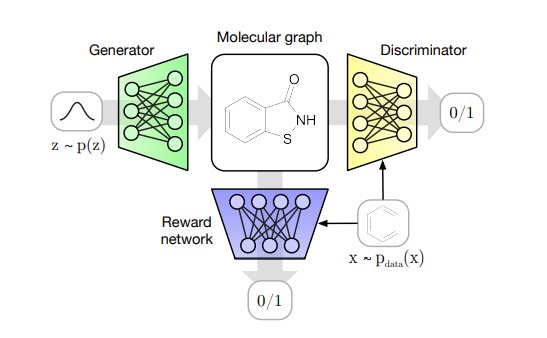 
Courtesy: https://arxiv.org/pdf/1805.11973.pdf

Explanation:

Gen Network:

    1) Generator Input --> z is a vector sampled from a priot distribution and sent to the generator

    2) Generator Output --> Graphical representation of the molecule

Dis Network:

    1) Discriminator Input --> The Graphical representation of the molecule

    2)Discriminator Output --> 1 or 0 --> 1 means it is from the data set and 0 means it is from the Generator

Additional Network: 

    Reward --> Reward for the chemical property of the molecule generated (rdkit helps here) ---> [0, 1]



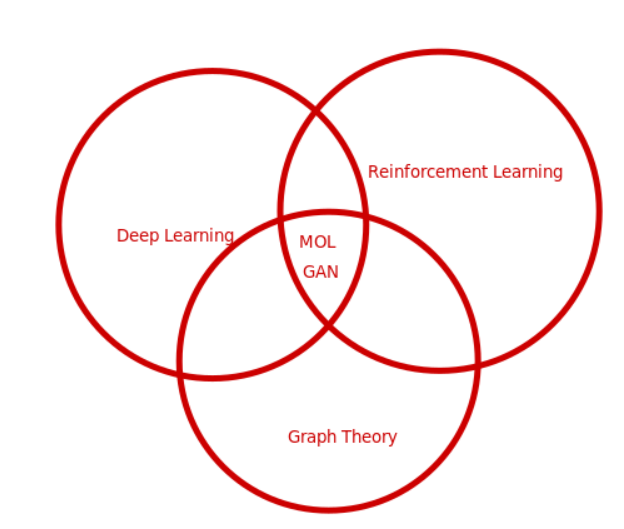

This paper is an intersection of various beautiful fields of Comp Sci like

1) Reinforcement Learning
2) Graph Theory
3) Deep Learning

Paper in Brief:

1) This paper was released in the year 2018 and updated in 2022 and talks about the generation of small molecular graphs which can be applied for various applications. The novel approach behind the idea of the paper is that it doesnt take into the consideration of likelihood, thereby using adversarial approaches. The results of the paper is fascinating that it produces a valid molecule which is close to 90% right. 


2) The broad idea is the following. 
    a) Molecular graphs are generated using Generator network
    b) SMILES approach is used to generated the chemical formula for the graph generated using RNN network
    c) RL network (Reward) is added to the Gen-Dis network to provide reward to the generated molecular graph (Reward is nothing but, desirable property to accomplish certain tasks in the future)
    

3) The molecular graph $ G $ has $ V $ as elements and $ E $ as edges connecting the elements, so its a $ G(V, E) $

4) From our course, we make use of the Gradient penalty applied WGAN with min max loss and the deterministic policy gradient approach to maximise the expected future reward which is nothing but the money we get when we take an action from the current state if the state is not already a terminal state 

5) The RL learning makes sure that the reward is None if the molecular graph generated is not a chemical compound

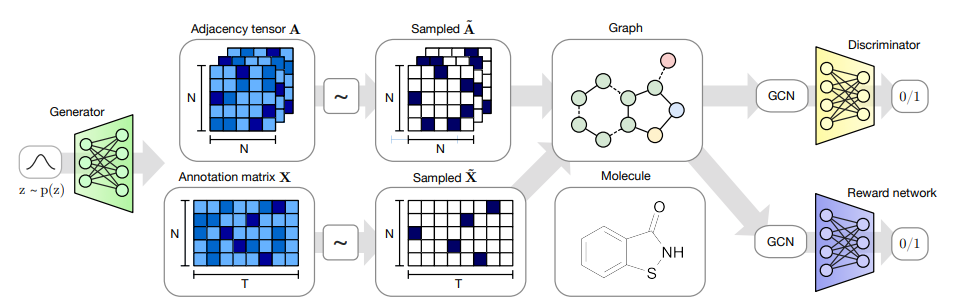

Courtesy: https://arxiv.org/pdf/1805.11973.pdf

Explanation:

Figure 2. Outline of MolGAN. From left: the generator takes a sample from a prior distribution and generates a dense adjacency tensor
A and an annotation matrix X. Subsequently, sparse and discrete A˜ and X˜ are obtained from A and X respectively via categorical
sampling. The combination of A˜ and X˜ represents an annotated molecular graph which corresponds to a specific chemical compound.
Finally, the graph is processed by both the discriminator and reward networks that are invariant to node order permutations and based on
Relational-GCN (Schlichtkrull et al., 2017) layers

1) Generator takes random noise and outputs adjacency matrix A $(N * N)$ and an annotation matrix X $(T * N)$
2) Then we sample $\tilde{A}$ and $\tilde{X}$ using Categorical Sampling (notice that both are sparse)
3) This gives the generated molecular graph and subsequently we annotate the graph with the SMILES with the help of rdkit package and obtain a compound
4) This generated compound is separately sent into Discriminator (0 or 1) and Reward Network [0, 1]

Loss functions are defined as below: 

\begin{align}
\ L({x^{(i)}, G_{\theta}(z^{(i)});{\phi}}) = -D_{\phi}(x^{(i)}) + D_{\phi}(G_{\phi}(z^{(i)}) \
\ + {\alpha}(|| {\nabla}_{\hat{x}^{(i)}} * D_{\phi}(\hat{x}^{(i)})|| - 1) ^ 2
\end{align}

\begin{align}
L({\theta}) = {\lambda} * L_{WGAN}{\theta} + (1 - {\lambda}) * L_{RL}{\theta}
\end{align}

In [17]:
import numpy as np
import torch
import torch.nn.functional as F
from rdkit import Chem, RDLogger
from torch import nn
from torch.nn.utils import clip_grad_value_
from torch.utils.data import DataLoader
from torch.distributions import Categorical
from torch.nn.modules.activation import Sigmoid
from allennlp.modules.feedforward import FeedForward
from allennlp.modules.seq2seq_encoders import (LstmSeq2SeqEncoder,PytorchTransformer)
from tqdm import tqdm

In [18]:
# Gen Network
class Generator(nn.Module):

    def __init__(self, latent_dim, vocab_size, start_token, end_token):

        super().__init__()

        # (-1) we do not need pad token for the generator
        self.vocab_size = vocab_size
        self.start_token = start_token
        self.end_token = end_token

        self.embedding_layer = nn.Embedding(self.vocab_size, latent_dim)

        self.project = FeedForward(
            input_dim=latent_dim,
            num_layers=2,
            hidden_dims=[latent_dim * 2, latent_dim * 2],
            activations=[nn.ReLU(), nn.ELU(alpha=0.1)],
            dropout=[0.1, 0.1]
        )

        self.rnn = nn.LSTMCell(latent_dim, latent_dim)

        self.output_layer = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(latent_dim, latent_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(latent_dim * 2, vocab_size - 1)
        )

    def forward(self, z, max_len=20):

        batch_size = z.shape[0]

        # start of sequence
        starts = torch.full(
            size=(batch_size,), fill_value=self.start_token, device=z.device).long()

        # embed_start
        emb = self.embedding_layer(starts)

        x = []
        log_probabilities = []
        entropies = []

        h, c = self.project(z).chunk(2, dim=1)

        for i in range(max_len):

            # new state
            h, c = self.rnn(emb, (h, c))

            # prediction
            logits = self.output_layer(h)

            # create dist
            dist = Categorical(logits=logits)

            # sample
            sample = dist.sample()

            # append prediction
            x.append(sample)

            # append log prob
            log_probabilities.append(dist.log_prob(sample))

            # append entropy
            entropies.append(dist.entropy())

            # new embedding
            emb = self.embedding_layer(sample)

        # stack along sequence dim
        x = torch.stack(x, dim=1)
        log_probabilities = torch.stack(log_probabilities, dim=1)
        entropies = torch.stack(entropies, dim=1)

        # keep only valid lengths (before EOS)
        end_pos = (x == self.end_token).float().argmax(dim=1).cpu()

        # sequence length is end token position + 1
        seq_lengths = end_pos + 1

        # if end_pos = 0 => put seq_length = max_len
        seq_lengths.masked_fill_(seq_lengths == 1, max_len)

        # select up to length
        _x = []
        _log_probabilities = []
        _entropies = []
        for x_i, logp, ent, length in zip(x, log_probabilities, entropies, seq_lengths):
            _x.append(x_i[:length])
            _log_probabilities.append(logp[:length])
            _entropies.append(ent[:length].mean())

        x = torch.nn.utils.rnn.pad_sequence(
            _x, batch_first=True, padding_value=-1)

        x = x + 1  # add padding token

        return {'x': x, 'log_probabilities': _log_probabilities, 'entropies': _entropies}

In [19]:
# Discriminator Network

class RecurrentDiscriminator(nn.Module):

    def __init__(self, hidden_size, vocab_size, start_token, bidirectional=True):

        super().__init__()

        self.start_token = start_token

        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=0)

        self.rnn = LstmSeq2SeqEncoder(
            hidden_size, hidden_size, num_layers=1, bidirectional=bidirectional)

        if bidirectional:
            hidden_size = hidden_size * 2

        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size * 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """[summary]

        Args:
            x ([type]): [description]

        Returns:
            [type]: [description]
        """

        batch_size, _ = x.size()

        # append start token to the input
        starts = torch.full(
            size=(batch_size, 1), fill_value=self.start_token, device=x.device).long()

        x = torch.cat([starts, x], dim=1)

        mask = x > 0

        # embed input [batch_size, max_len, hidden_size]
        emb = self.embedding(x)

        # contextualize representation
        x = self.rnn(emb, mask)

        # prediction for each sequence
        out = self.fc(x).squeeze(-1)  # [B, max_len]

        return {'out': out[:, 1:], 'mask': mask.float()[:, 1:]}

In [20]:
# FULL MODEL

RDLogger.DisableLog('rdApp.*')

class MolGen(nn.Module):

    def __init__(self, data, hidden_dim=128, lr=1e-3, device='cpu'):
        super().__init__()

        self.device = device
        self.hidden_dim = hidden_dim
        self.tokenizer = Tokenizer(data)

        self.generator = Generator(
            latent_dim=hidden_dim,
            vocab_size=self.tokenizer.vocab_size - 1,
            start_token=self.tokenizer.start_token - 1,  # no need token
            end_token=self.tokenizer.end_token - 1,
        ).to(device)

        self.discriminator = RecurrentDiscriminator(
            hidden_size=hidden_dim,
            vocab_size=self.tokenizer.vocab_size,
            start_token=self.tokenizer.start_token,
            bidirectional=True
        ).to(device)

        self.generator_optim = torch.optim.Adam(
            self.generator.parameters(), lr=lr)

        self.discriminator_optim = torch.optim.Adam(
            self.discriminator.parameters(), lr=lr)

        self.b = 0.  # baseline reward

    def sample_latent(self, batch_size):
        
        return torch.randn(batch_size, self.hidden_dim).to(self.device)

    def discriminator_loss(self, x, y):

        y_pred, mask = self.discriminator(x).values()
        loss = F.binary_cross_entropy(
            y_pred, y, reduction='none') * mask
        loss = loss.sum() / mask.sum()

        return loss

    def train_step(self, x):

        batch_size, len_real = x.size()

        # create real and fake labels
        x_real = x.to(self.device)
        y_real = torch.ones(batch_size, len_real).to(self.device)

        # sample latent var
        z = self.sample_latent(batch_size)
        generator_outputs = self.generator.forward(z, max_len=20)
        x_gen, log_probs, entropies = generator_outputs.values()

        # label for fake data
        _, len_gen = x_gen.size()
        y_gen = torch.zeros(batch_size, len_gen).to(self.device)

        #####################
        # Train Discriminator
        #####################

        self.discriminator_optim.zero_grad()

        # disc fake loss
        fake_loss = self.discriminator_loss(x_gen, y_gen)

        # disc real loss
        real_loss = self.discriminator_loss(x_real, y_real)

        # combined loss
        discr_loss = 0.5 * (real_loss + fake_loss)
        discr_loss.backward()

        # clip grad
        clip_grad_value_(self.discriminator.parameters(), 0.1)

        # update params
        self.discriminator_optim.step()

        # ###############
        # Train Generator
        # ###############

        self.generator_optim.zero_grad()

        # prediction for generated x
        y_pred, y_pred_mask = self.discriminator(x_gen).values()

        # Reward (see the ref paper)
        R = (2 * y_pred - 1)

        # reward len for each sequence
        lengths = y_pred_mask.sum(1).long()

        # list of rew of each sequences
        list_rewards = [rw[:ln] for rw, ln in zip(R, lengths)]

        # compute - (r - b) log x
        generator_loss = []
        for reward, log_p in zip(list_rewards, log_probs):

            # substract the baseline
            reward_baseline = reward - self.b

            generator_loss.append((- reward_baseline * log_p).sum())

        # mean loss + entropy reg
        generator_loss = torch.stack(generator_loss).mean() - \
            sum(entropies) * 0.01 / batch_size

        # baseline moving average
        with torch.no_grad():
            mean_reward = (R * y_pred_mask).sum() / y_pred_mask.sum()
            self.b = 0.9 * self.b + (1 - 0.9) * mean_reward

        generator_loss.backward()

        clip_grad_value_(self.generator.parameters(), 0.1)

        self.generator_optim.step()

        return {'loss_disc': discr_loss.item(), 'mean_reward': mean_reward}

    def create_dataloader(self, data, batch_size=128, shuffle=True, num_workers=5):

        return DataLoader(
            data,
            batch_size=batch_size,
            shuffle=shuffle,
            collate_fn=self.tokenizer.batch_tokenize,
            num_workers=num_workers
        )

    def train_n_steps(self, train_loader, max_step=10000, evaluate_every=1000):

        iter_loader = iter(train_loader)

        # best_score = 0.0
        for step in tqdm(range(max_step)):
            try:
                batch = next(iter_loader)
            except:
                iter_loader = iter(train_loader)
                batch = next(iter_loader)

            # model update
            self.train_step(batch)

            if step % evaluate_every == 0:
                self.eval()
                score = self.evaluate_n(1000)
                self.train()

                # if score > best_score:
                #     self.save_best()
                #     print('saving')
                #     best_score = score

                print(f'valid = {score: .2f}')

    def get_mapped(self, seq):
        return ''.join([self.tokenizer.inv_mapping[i] for i in seq])

    @torch.no_grad()
    def generate_n(self, n):

        z = torch.randn((n, self.hidden_dim)).to(self.device)
        x = self.generator(z)['x'].cpu()
        lenghts = (x > 0).sum(1)

        # l - 1 because we exclude end tokens
        return [self.get_mapped(x[:l-1].numpy()) for x, l in zip(x, lenghts)]

    def evaluate_n(self, n):

        pack = self.generate_n(n)
        # print(pack)
        valid = np.array([Chem.MolFromSmiles(k) is not None for k in pack])
        
        return valid.mean()

In [21]:
# Tokenizer

class Tokenizer(object):

    def __init__(self, data):
        unique_char = list(set(''.join(data))) + ['<eos>'] + ['<sos>']
        self.mapping = {'<pad>': 0}
        for i, c in enumerate(unique_char, start=1):
            self.mapping[c] = i

        self.inv_mapping = {v: k for k, v in self.mapping.items()}
        self.start_token = self.mapping['<sos>']
        self.end_token = self.mapping['<eos>']
        self.vocab_size = len(self.mapping.keys())

    def encode_smile(self, mol, add_eos=True):
        out = [self.mapping[i] for i in mol]

        if add_eos:
            out = out + [self.end_token]
        return torch.LongTensor(out)

    def batch_tokenize(self, batch):

        out = map(lambda x: self.encode_smile(x), batch)
        return torch.nn.utils.rnn.pad_sequence(list(out), batch_first=True)

In [22]:
# load data

data = []
with open('qm9.csv', "r") as f:
    for line in f.readlines()[1:]:
        data.append(line.split(",")[1])

# create model
cuda = 'cuda:0'
device = torch.device(cuda if torch.cuda.is_available() else "cpu")
gan_mol = MolGen(data, hidden_dim=64, lr=1e-3, device=device)

In [23]:
# create dataloader
loader = gan_mol.create_dataloader(data, batch_size=128, shuffle=True, num_workers=10)

# train model for 10000 steps
gan_mol.train_n_steps(loader, max_step=10000, evaluate_every=1000)

  0%|          | 1/10000 [00:01<4:25:07,  1.59s/it]

valid =  0.01


  0%|          | 5/10000 [00:05<3:15:47,  1.18s/it]


KeyboardInterrupt: 

In [ ]:
gan_mol.eval()

print('ok')

['CCC1OC1C', 'O=C1C=CCC12', 'CC1COC2CC12', 'CC1OCC11CC1', 'CC1=CC2NCC12', 'CC1=CC2CC12']
[<rdkit.Chem.rdchem.Mol object at 0x7f85e77bb120>, None, <rdkit.Chem.rdchem.Mol object at 0x7f85e77bbee0>, <rdkit.Chem.rdchem.Mol object at 0x7f849c2632b0>, <rdkit.Chem.rdchem.Mol object at 0x7f849c263f30>, <rdkit.Chem.rdchem.Mol object at 0x7f8579ae6a30>]


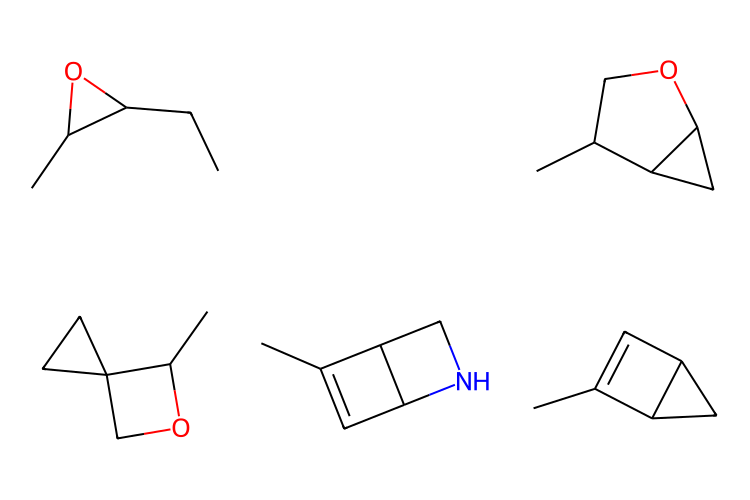

In [65]:
# After training
# generate Smiles molecules
smiles_list = gan_mol.generate_n(6)
print(smiles_list)
# convert with rdkit
mol_list = [Chem.MolFromSmiles(m) for m in smiles_list]
print(mol_list)
# draw
Chem.Draw.MolsToGridImage(mol_list, molsPerRow=3, subImgSize=(250, 250), maxMols=10)